In [1]:
import cv2
import time
import numpy as np
import pandas as pd

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import models
import albumentations as A
from albumentations.pytorch import ToTensorV2, transforms

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline
#----------------------------------------------------------------------------------------------------

def get_next_state(model,p,d,sp,zoom,n):
    '''
    model - in gpu in eval mode
    p     - tensor of frame with variables in [-1,1]
    d     - direction, one of {1,2,3,4,5,6,7,8}
    sp    - sp in current frame, int/float
    zoom  - zoom in current frame, one of {1} (обучал только для zoom=1)
    n     - number of timestamps, one of {1,2,3,4,5,6,7,8,9,10,11,12,13,14}
    '''
    p = torch.clone(p).to(device)
    d = F.one_hot(torch.tensor(d-1), num_classes=8)
    sp = torch.tensor(sp)/100
    zoom = torch.tensor(dg['zoom'][i])/15
    n = torch.tensor(n/14)
    dd2 = torch.cat([d,
                     sp.unsqueeze(0),
                     zoom.unsqueeze(0),
                     n.unsqueeze(0)]).unsqueeze(0).float().to(device)
    with torch.no_grad():
        p = model((p.unsqueeze(0),dd2))[0]
    return p

def see_plot(pict, size=(6,6)):
    plt.figure(figsize=size)
    plt.imshow(pict,cmap='gray') #, cmap=color, color='gray'
    #plt.xticks([j for j in range(0,96*3,12)])
    plt.grid()
    plt.show()

def load_image(video, frame):
    path = '/media/laggg/surviv_rl_data/all_videoframes_rgb_96/{}/'.format(video)
    p = cv2.imread(path + 'f_{}.jpg'.format(frame))
    return p[:,:,::-1]
#----------------------------------------------------------------------------------------------------

# data
dg = pd.read_csv('/media/laggg/surviv_rl_data/dataset_inventory_v2.csv')
dg = dg[dg.zoom==1].reset_index()
#----------------------------------------------------------------------------------------------------

# info
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('device:', device)

device: cuda:0


In [2]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

class ResNetUNet_v2(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=True)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        self.dropout = nn.Dropout(0.5)
        self.conv_last = nn.Conv2d(64, n_class, 1)
        self.act_last = nn.Tanh()
        self.support_conv1 = nn.Conv2d(11, 512, 1) # (bath,10+1) --> (batch,512)
        
    def forward(self, inp):

        x_original = self.conv_original_size0(inp[0])
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(inp[0])            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        cond = self.support_conv1(torch.unsqueeze(torch.unsqueeze(inp[1], 2), 2)) # ([8, 8]) --> Size([8, 512, 1, 1])
        layer4 = self.layer4_1x1(layer4+cond)
        
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        x = self.dropout(x)
        out = self.conv_last(x)
        out = self.act_last(out)
        
        return out

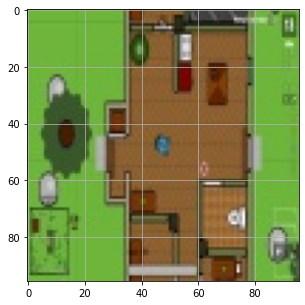

In [3]:
# preproc data
i = 10
p = load_image(dg['video'][i], dg['frame'][i])
sp = dg['sp'][i]
zoom = dg['zoom'][i]

train_aug = A.Compose([A.Normalize(mean=(0.5,), std=(0.5,)),
                       ToTensorV2(transpose_mask=False),
                      ])
p = train_aug(image=p)['image']

# visual
see_plot(p.permute(1,2,0)/2+0.5, (5,5))

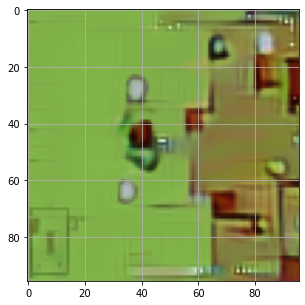

In [4]:
model = ResNetUNet_v2(3)
model.load_state_dict(torch.load('./best_models/resunet_v5.pth'))
model = model.to(device)
model.train(False);


picts = []
for i in range(10):
    d = 7
    n = 4
    p = get_next_state(model,p,d,sp,zoom,n)
    
    display.clear_output(wait=True)
    temp = p.permute(1,2,0).detach().cpu()/2+0.5
    picts.append(temp)
    see_plot(temp, (5,5))
    time.sleep(0.1)

In [5]:
# make .gif
from PIL import Image

imgs = np.zeros((len(picts), picts[0].shape[0], picts[0].shape[1], picts[0].shape[2]))
for i in range(len(picts)):
    imgs[i] = picts[i]
#print(imgs.shape)

imgs = [Image.fromarray(img) for img in (imgs*255).astype(np.uint8)]
imgs[0].save("test.gif", save_all=True, append_images=imgs[1:], duration=[0.3]*len(picts), loop=0)